In [ ]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# read csv

# Read CSV files
high_launch_data = pd.read_csv('data/carmf5_HIGHDATA.CSV')
low_launch_data = pd.read_csv('data/carmf5_LOWDATA.CSV')

/tmp/ipykernel_6582/3531909341.py:9: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  high_launch_data = pd.read_csv('data/carmf5_HIGHDATA.CSV')
/tmp/ipykernel_6582/3531909341.py:10: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  low_launch_data = pd.read_csv('data/carmf5_LOWDATA.CSV')


In [7]:
# clear bad data

del high_launch_data['STATE']
del high_launch_data['engine bay temperature (C)']
del high_launch_data['external temperature (C)']
del high_launch_data['kf vertical velocity (m/s)']
del high_launch_data['kf vertical acceleration (m/s^2)']
del high_launch_data['kf altitude (m)']
del high_launch_data['gps lat']
del high_launch_data['gps long']
del high_launch_data['gps speed']
del high_launch_data['gps angle']
del high_launch_data['gps altitude']
del high_launch_data['gps fix']
del high_launch_data['gps fix quality']
del high_launch_data['gps satellites']
del high_launch_data['gps antenna status']
del high_launch_data['error flags']

# do low data later


In [8]:
# calculate k means

def k_means(data, k, max_iterations=100):
    centroids = initialize_centroids(data, k) # some random initialization for centroids (codebook)
    for iteration in range(max_iterations): # some convergence criteria
        # Assign data points to the nearest centroid -- this is the partition step
        clusters = assign_data_to_centroids(data, centroids)
        # Calculate new centroids -- this is the codebook update step
        new_centroids = calculate_new_centroids(data, clusters)
        # Check for convergence
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids # update centroids
    return clusters, centroids

def initialize_centroids(data, k):
    # Randomly select k data points as initial centroids
    return data[np.random.choice(len(data), k, replace=False)]

def assign_data_to_centroids(data, centroids):
    # Assign each data point to the nearest centroid
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    clusters = np.argmin(distances, axis=1)
    return clusters

def calculate_new_centroids(data, clusters):
    # Calculate new centroids as the mean of data points in each cluster
    new_centroids = np.array([data[clusters == i].mean(axis=0) for i in range(len(np.unique(clusters)))])
    return new_centroids

def error(data, clusters, centroids):
    return np.array([np.sum(np.square(np.linalg.norm(data[clusters==i] - centroids[i], axis=1))) for i in range(len(np.unique(clusters)))])

def error_per_k(data, k, iterations=20):
    #clusters,centroids = k_means(data, k, iterations)
    white_data = sp.cluster.vq.whiten(data)
    centroids,_ = sp.cluster.vq.kmeans(white_data, k, iter=iterations)
    clusters = assign_data_to_centroids(white_data, centroids)
    print("Calculated centroids!")
    return error(white_data, clusters, centroids)

high_np = high_launch_data.to_numpy()



calculated distances for  55
(36083,) 7162.815114347511


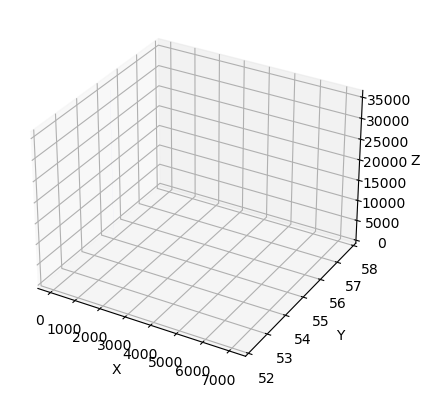

In [43]:
def hist3d(data, z, bin_count):
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')
    for zv in z:
        counts, bins = np.histogram(data, bins=bin_count)

        # You can provide either a single color or an array. To demonstrate this,
        # the first bar of each set will be colored cyan.
        ax.bar(bins[:-1], counts, zs=zv, color='b', zdir='y', alpha=0.8)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

def error_per_distance(data, k, iterations=30):
    white_data = sp.cluster.vq.whiten(data)
    centroids,_ = sp.cluster.vq.kmeans(white_data, k, iter=iterations)
    clusters = assign_data_to_centroids(white_data, centroids)
    distances = np.array([np.square(np.linalg.norm(white_data[i] - centroids[clusters[i]])) for i in range(white_data.shape[0])])
    print("calculated distances for ", k)
    max_dist = np.max(distances)
    print(distances.shape, max_dist)
    return distances

#error_per_distance(high_np, 45)
#error_per_distance(high_np, 70)

ks = np.array([55])#np.array([30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])
distance_data = np.array([error_per_distance(high_np, k, iterations=1) for k in ks])
hist3d(distance_data, ks, 100)


In [ ]:
min_clusters = 10
max_clusters = 100
X = np.array(range(min_clusters, max_clusters + 1))
Y = np.array([np.sum(error_per_k(high_np, i)) for i in range(min_clusters, max_clusters + 1)])
print("calculated clusters")
plt.plot(X, Y)
print("plotted output")
plt.show()

In [23]:
min_clusters_2 = 40
max_clusters_2 = 60
X2 = np.array(range(min_clusters_2, max_clusters_2 + 1))
Y2 = np.array([np.sum(error_per_k(high_np, i, 5)) for i in range(min_clusters_2, max_clusters_2 + 1)])
print("calculated clusters")
plt.plot(X2, Y2)
print("plotted output")
plt.show()


KeyboardInterrupt: 